In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *
from sklearn.linear_model import LinearRegression, Lasso
import seaborn as sns

### Load a random firing rate file

In [2]:
frs = pd.read_pickle("/data/patrick_res/firing_rates/SA/20180615_firing_rates_1300_FeedbackOnset_1500_100_bins_1_smooth.pickle")

In [36]:
def regress_unit_bin(group):
    y = group.FiringRate
    x = group.TrialNumber.values.reshape(-1, 1)
    reg = LinearRegression().fit(x, y)
    y_pred = reg.predict(x)
    group["FiringRate"] = group["FiringRate"] - y_pred
    return group

frs.groupby(["TimeBins", "UnitID"], group_keys=False).apply(regress_unit_bin)

,TrialNumber,UnitID,TimeBins,SpikeCounts,FiringRate
0,0,0,0.0,1.0,1.960638
1,0,0,0.1,0.0,-0.525643
2,0,0,0.2,0.0,-0.469871
3,0,0,0.3,1.0,0.759509
4,0,0,0.4,0.0,-0.851638
...,...,...,...,...,...
794971,727,38,2.3,0.0,-1.797837
794972,727,38,2.4,0.0,-1.841359
794973,727,38,2.5,0.0,-0.129360
794974,727,38,2.6,1.0,1.409070


### Try out ideas from Alvarado et al., 2021
https://www.notion.so/walkerlab/Proposal-regressing-time-out-of-neural-activity-1ac2dc9f99928000818adba668f449ef 


Try to regress by trial number first, then project neural activity into that trial number vector... 
What's that going to look like?

In [50]:
def regress_unit_bin(group):

    frs = group.sort_values(by=["TrialNumber", "UnitID"]).FiringRate.values.reshape(group.TrialNumber.nunique(), -1)
    trial_numbers = group.sort_values(by=["TrialNumber"]).TrialNumber.unique().reshape(-1, 1)
    # print(frs.shape)
    # print(trial_numbers.shape)
    reg = Lasso(alpha=100).fit(trial_numbers, frs)
    unit_ids = group.UnitID.sort_values().unique()
    # print(reg.intercept_.shape)
    # print(len(unit_ids))
    # print(reg.coef_.shape)
    return pd.DataFrame({"UnitID": unit_ids, "coef": reg.coef_.reshape(-1), "bias": reg.intercept_})
    # # group["coef"] = reg.coef_[0]
    # # group["bias"] = reg.intercept_
    # return group

res = frs.groupby(["TimeBins"]).apply(regress_unit_bin).reset_index()
res = pd.merge(res, frs, on=["TimeBins", "UnitID"])
res["proj_fr"] = res["FiringRate"] * res["coef"] + res["bias"]
# res["proj_fr"] = (res["FiringRate"] - res["bias"]) / res["coef"]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

<Axes: >

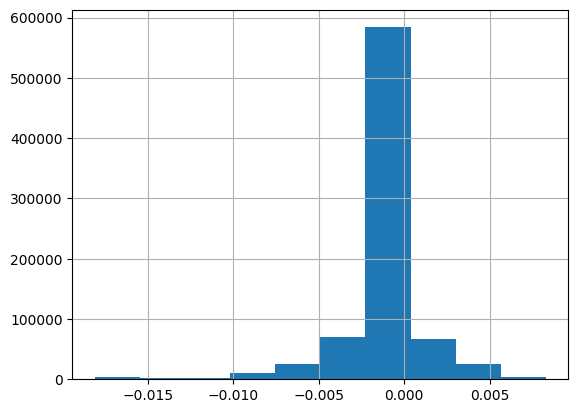

In [51]:
res.coef.hist()

In [52]:
summed = res.groupby(["TimeBins", "TrialNumber"]).proj_fr.sum().reset_index(name="sum_proj")

/tmp/ipykernel_2446595/1858845556.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub["sum_proj_smoothed"] = np.convolve(sub["sum_proj"], weights, mode='same')
/tmp/ipykernel_2446595/1858845556.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub["sum_proj_smoothed"] = np.convolve(sub["sum_proj"], weights, mode='same')
/tmp/ipykernel_2446595/1858845556.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

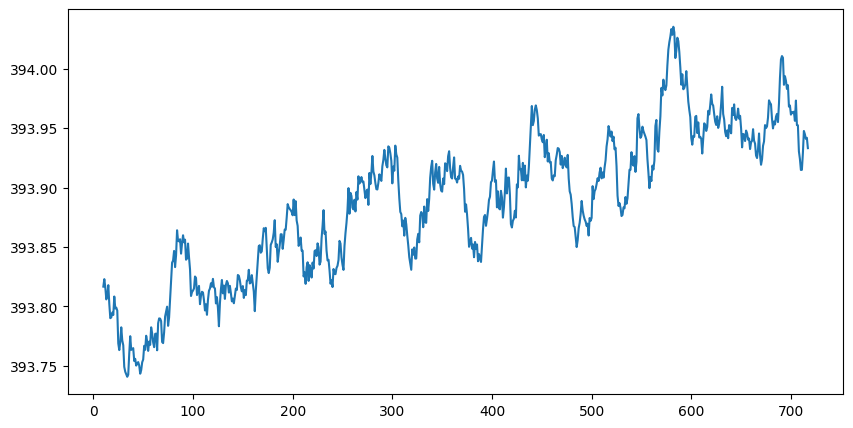

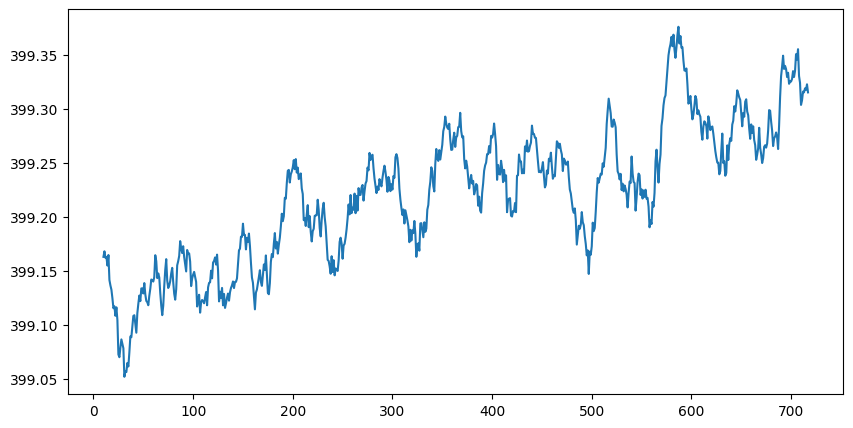

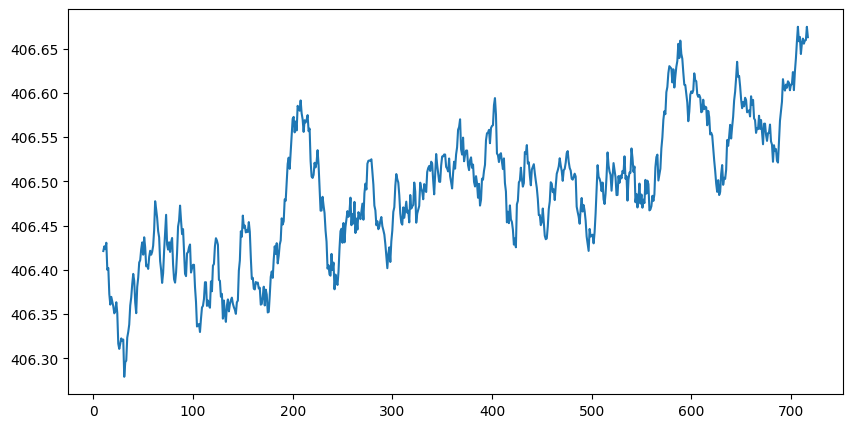

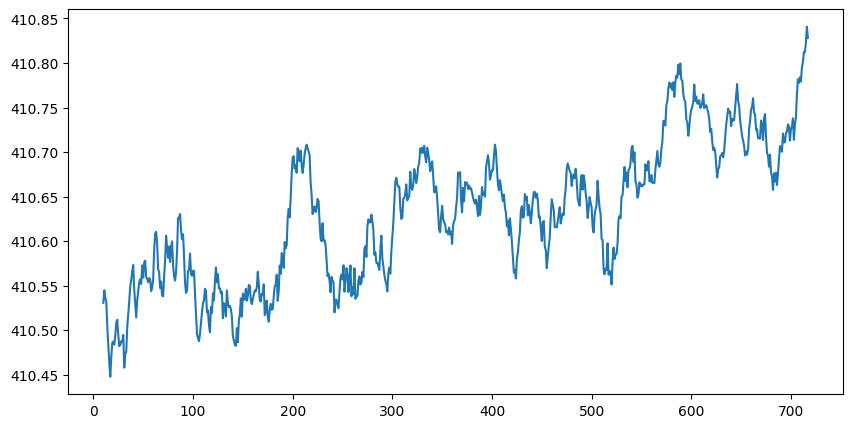

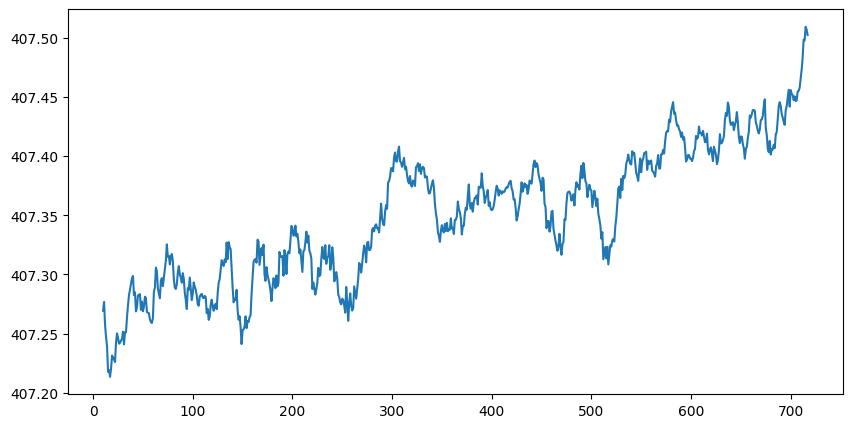

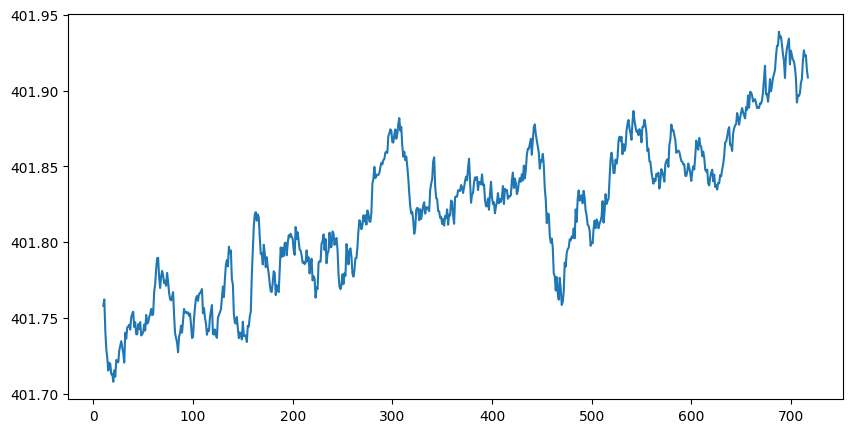

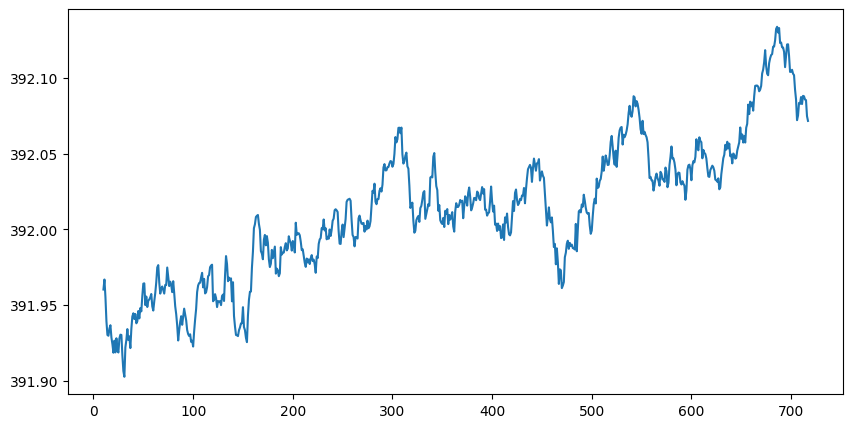

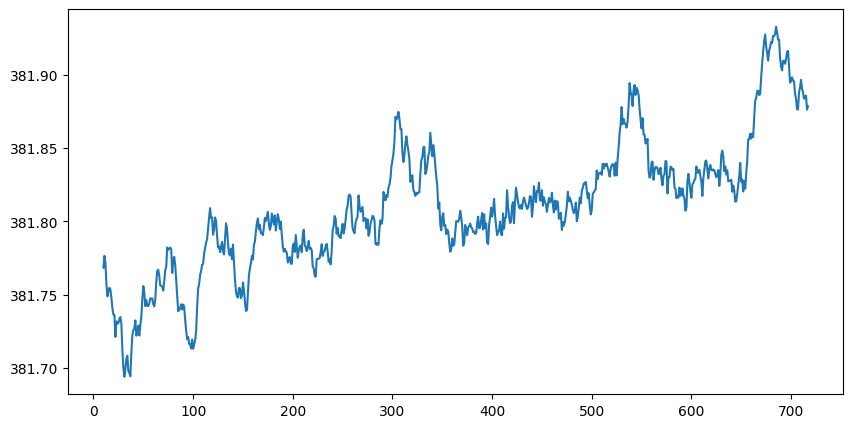

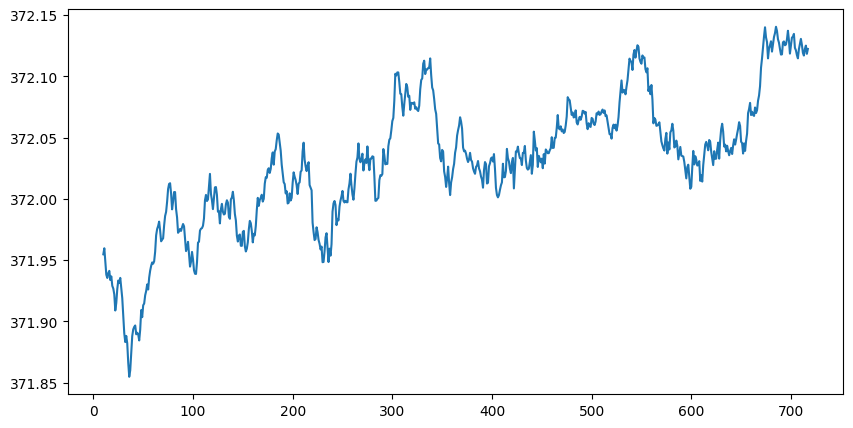

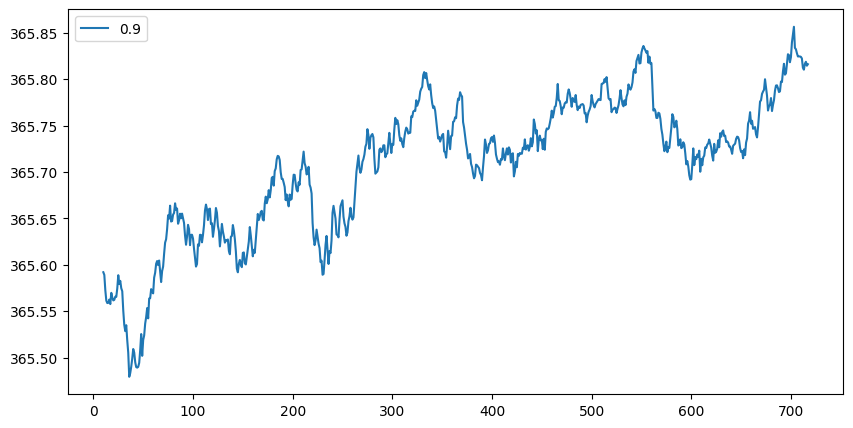

In [55]:
time_bins = summed.TimeBins.unique()[:10]

for time_bin in time_bins: 
    sub = summed[summed["TimeBins"] == time_bin]

    window_size = 20
    weights = np.ones(window_size) / window_size
    sub["sum_proj_smoothed"] = np.convolve(sub["sum_proj"], weights, mode='same')
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(sub["TrialNumber"].values[10:-10], sub["sum_proj_smoothed"].values[10:-10], label=time_bin)
ax.legend()

In [20]:
summed

,TimeBins,TrialNumber,sum_proj
0,0.0,0,399.067765
1,0.0,1,399.312409
2,0.0,2,398.918364
3,0.0,3,399.110893
4,0.0,4,398.904276
...,...,...,...
20379,2.7,723,356.214004
20380,2.7,724,357.035580
20381,2.7,725,356.730377
20382,2.7,726,356.776869


### Scratch code

In [7]:
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils

behavior_path = f"/data/patrick_res/behavior/SA/20180802_object_features.csv"
beh = pd.read_csv(behavior_path)
valid_beh = beh[beh.Response.isin(["Correct", "Incorrect"])]
spike_times = spike_general.get_spike_times(None, "SA", "20180802", species_dir="/data")

print("Calculating spikes by trial interval")
interval_size_secs = 100  / 1000
intervals = behavioral_utils.get_trial_intervals(valid_beh, "FeedbackOnset", 1300, 1500)
spike_by_trial_interval = spike_utils.get_spikes_by_trial_interval(spike_times, intervals)

end_bin = (1300 + 1500) / 1000 + interval_size_secs

all_units = spike_general.list_session_units(None, "SA", "20180802", species_dir="/data")
print(len(all_units))
print("Calculating Firing Rates")
firing_rates = spike_analysis.firing_rate(
    spike_by_trial_interval, 
    all_units, 
    bins=np.arange(0, end_bin, interval_size_secs), 
    smoothing=1,
    trials=valid_beh.TrialNumber.unique()
)

Calculating spikes by trial interval
46
Calculating Firing Rates


In [11]:
merged = pd.merge(firing_rates, intervals, on="TrialNumber")

In [13]:
merged["BinTime"] = merged.IntervalStartTime + merged.TimeBins * 1000

<Axes: >

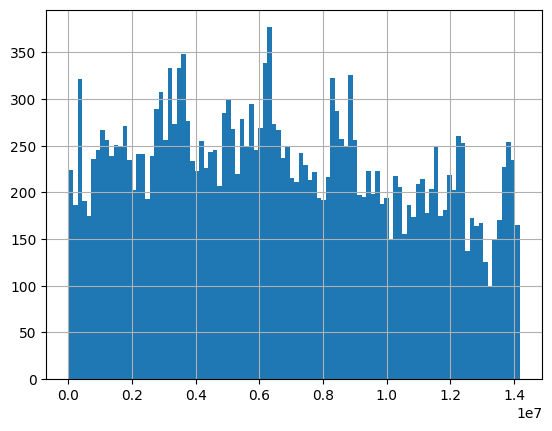

In [33]:
unit_spike_times = spike_times[spike_times.UnitID == 10]
unit_spike_times.SpikeTime.hist(bins=100)

<Axes: >

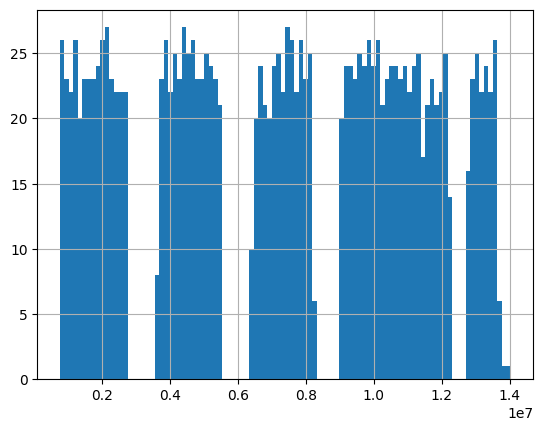

In [23]:
beh.FixationOnCross.hist(bins=100)